<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size=+3>Predicting the Winning College Basketball Team</font></h1>

<img src="https://images.unsplash.com/photo-1583359312696-cbc5d73e5f8d?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1285&q=80" width = 400>
<center><em>Photo by Sheri Hooley (Unsplash)</em></center>

**Table of Contents**

1. [Libraries](#Libraries)
2. [The Dataset](#The-Dataset)
3. [Data Visualisation](#Data-Visualisation)
4. [Pre-processing](#Pre-processing)
5. [Building Machine Learning Models](#Building-Machine-Learning-Models)
6. [Model Evaluation using the Test Set](#Model-Evaluation-using-the-Test-Set)
7. [Report](#Report)
8. [Future Development](#Future-Development)
9. [Conclusions](#Conclusions)

<br>

# Libraries

The first step in our analysis is loading the required libraries.

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
# for f1_score please set the average parameter to 'micro'

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

We also need to write a function for the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index).

In [2]:
def jaccard_index(true, predictions):
    if (len(predictions) == len(true)):
        intersect = 0;
        for x,y in zip(predictions, true):
            if (x == y):
                intersect += 1
        return intersect / (len(predictions) + len(true) - intersect)
    else:
        return -1

# The Dataset

The **cbb.csv** dataset contains information about Division I college basketball teams over four seasons. Specifically, it includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|TEAM |	The Division I college basketball school|
|CONF|	The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)|
|G|	Number of games played|
|W|	Number of games won|
|ADJOE|	Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)|
|ADJDE|	Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)|
|BARTHAG|	Power Rating (Chance of beating an average Division I team)|
|EFG_O|	Effective Field Goal Percentage Shot|
|EFG_D|	Effective Field Goal Percentage Allowed|
|TOR|	Turnover Percentage Allowed (Turnover Rate)|
|TORD|	Turnover Percentage Committed (Steal Rate)|
|ORB|	Offensive Rebound Percentage|
|DRB|	Defensive Rebound Percentage|
|FTR|	Free Throw Rate (How often the given team shoots Free Throws)|
|FTRD|	Free Throw Rate Allowed|
|2P_O|	Two-Point Shooting Percentage|
|2P_D|	Two-Point Shooting Percentage Allowed|
|3P_O|	Three-Point Shooting Percentage|
|3P_D|	Three-Point Shooting Percentage Allowed|
|ADJ_T|	Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)|
|WAB|	Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)|
|POSTSEASON|	Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)|
|SEED|	Seed in the NCAA March Madness Tournament|
|YEAR|	Season

Let's load the dataset:

In [3]:
df = pd.read_csv('cbb.csv')

print('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 1406 rows and 24 columns.


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


## Column 'windex'

Next, we'll add a column that will contain "true" if the wins above bubble are over 7 and "false" if not. We'll call this column Win Index or "windex" for short. 

In [4]:
df['windex'] = np.where(df['WAB'] > 7, 'True', 'False')

In [5]:
df[['WAB', 'windex']].head()

,WAB,windex
0,8.6,True
1,8.9,True
2,2.3,False
3,8.6,True
4,11.6,True


# Data Visualisation

Next, we'll filter the data set to the teams that made the Sweet Sixteen, the Elite Eight, and the Final Four in the postseason. We'll also create a new dataframe that will hold the values with the new column.

In [6]:
df1 = df.loc[df['POSTSEASON'].str.contains('S16|E8|F4', na = False)]
df1.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,False
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,True
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,True
5,Oregon,P12,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,...,52.6,46.1,34.4,36.2,69.0,6.7,E8,1.0,2016,False
6,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016,False


In [7]:
df1['POSTSEASON'].value_counts()

S16    32
E8     16
F4      8
Name: POSTSEASON, dtype: int64

32 teams made it into the Sweet Sixteen, 16 into the Elite Eight, and 8 made it into the Final Four over 5 seasons. 

Let's plot some columns to understand data better:

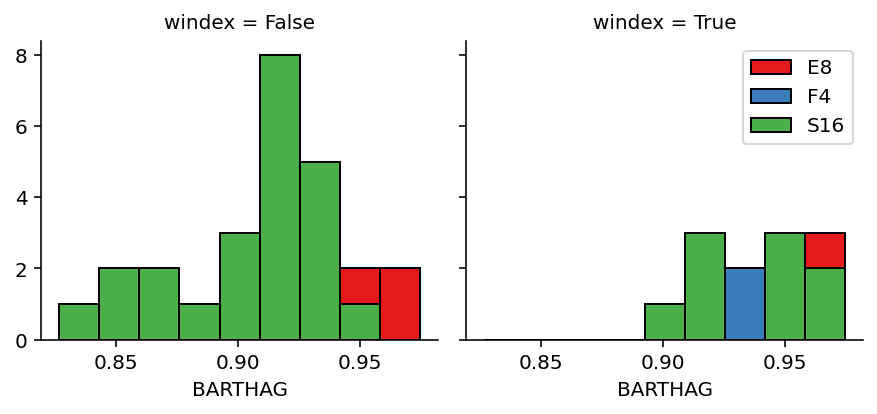

In [8]:
bins = np.linspace(df1['BARTHAG'].min(), df1['BARTHAG'].max(), 10)

g = sns.FacetGrid(df1, col = 'windex', hue = 'POSTSEASON', 
                  palette = 'Set1', col_wrap = 6)
g.map(plt.hist, 'BARTHAG', bins = bins, ec = 'k')

g.axes[-1].legend();

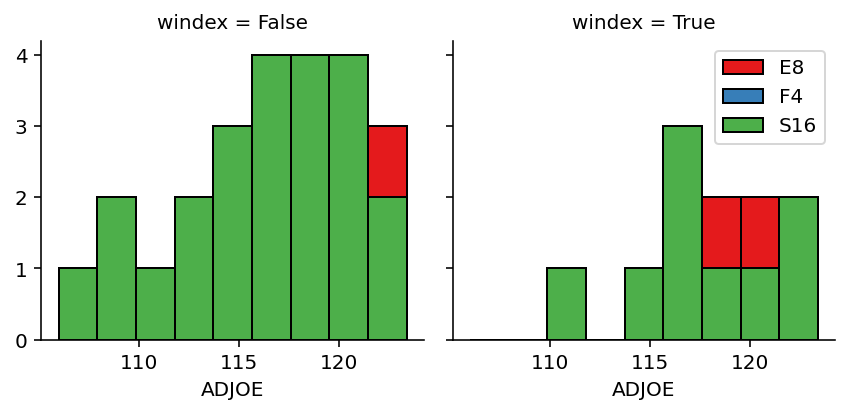

In [9]:
bins = np.linspace(df1['ADJOE'].min(), df1['ADJOE'].max(), 10)

g = sns.FacetGrid(df1, col = 'windex', hue = 'POSTSEASON', 
                  palette = 'Set1', col_wrap = 2)
g.map(plt.hist, 'ADJOE', bins = bins, ec = 'k')

g.axes[-1].legend();

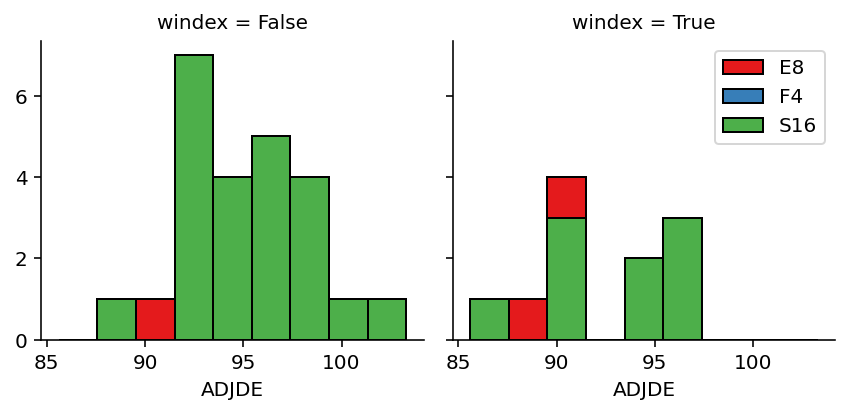

In [10]:
bins = np.linspace(df1['ADJDE'].min(), df1['ADJDE'].max(), 10)

g = sns.FacetGrid(df1, col = 'windex', hue = 'POSTSEASON', 
                  palette = 'Set1', col_wrap = 2)

g.map(plt.hist, 'ADJDE', bins = bins, ec = 'k')
g.axes[-1].legend();

# Pre-processing

## Converting Categorical Features to Numerical

Let's look at the postseason:

In [11]:
df1.groupby(['windex'])['POSTSEASON'].value_counts(normalize = True)

windex  POSTSEASON
False   S16           0.605263
        E8            0.263158
        F4            0.131579
True    S16           0.500000
        E8            0.333333
        F4            0.166667
Name: POSTSEASON, dtype: float64

13% of teams with 6 or fewer wins above bubble make it into the final four while 17% of teams with 7 or more do.

We will now convert wins above bubble (windex) under 7 to 0 and over 7 to 1:

In [12]:
df1['windex'].replace(to_replace = ['False', 'True'], value = [0, 1], inplace = True)
df1.head()

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,0
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,1
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,1
5,Oregon,P12,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,...,52.6,46.1,34.4,36.2,69.0,6.7,E8,1.0,2016,0
6,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016,0


## Feature Selection

The feature set, X, is defined as follows:

In [13]:
X = df1[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 
         'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
         '3P_D', 'ADJ_T', 'WAB', 'SEED', 'windex']]
X[0:5]

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,windex
2,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,14.8,32.7,...,32.9,26.0,52.9,46.5,37.4,36.9,65.5,2.3,6.0,0
3,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,18.8,29.9,...,32.1,33.4,52.6,46.3,40.3,34.7,61.9,8.6,1.0,1
4,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,18.5,32.2,...,38.6,37.3,52.7,43.4,41.3,32.5,70.1,11.6,1.0,1
5,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,20.2,34.1,...,40.3,32.0,52.6,46.1,34.4,36.2,69.0,6.7,1.0,0
6,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,20.4,33.5,...,35.4,28.0,47.2,48.1,36.0,30.7,65.5,-0.3,10.0,0


The label set, y, is defined as follows:

In [14]:
y = df1['POSTSEASON'].values
y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)

## Normalising our Data 

Data Standardisation results in data with zero mean and unit variance (technically it should be done after splitting the data into a training and test set, as this protects us from data leakage – the task asks us to do it now, so we will stick to it.).

In [15]:
X = StandardScaler().fit(X).transform(X)

## Training and Validation 

We will use scikit-learn's `train_test_split()` function to split our dataset into a training and validation set.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 4)

print('Shape')
print('     Train set: {} rows x {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Validation set: {} rows x {} columns'.format(X_val.shape[0], X_val.shape[1]))

Shape
     Train set: 44 rows x 21 columns
Validation set: 12 rows x 21 columns


# Building Machine Learning Models

We will now use the training set to build an accurate model, then use the validation set to report the accuracy of the model.

We should use the following algorithms:


- k-Nearest Neighbors (kNN),
- Decision Tree Classifier,
- Support Vector Machine Classifier, and
- Logistic Regression.

## k Nearest Neighbor (kNN)

<font size=+1 color='firebrick'><b>Question 1:</b></font> Build a kNN model using a value of *k* equals five, find the accuracy on the validation data (X_val and y_val).

In [17]:
neighbors = KNeighborsClassifier(n_neighbors = 5)
neighbors.fit(X_train, y_train)

y_hat = neighbors.predict(X_val)

We can use scikit-learn's <code>accuracy_score</code>:

In [18]:
acc = accuracy_score(y_val, y_hat)
print ('KNN with k = 5 | Accuracy = ', np.round(acc, 3))

KNN with k = 5 | Accuracy =  0.667


<font size=+1 color='firebrick'><b>Question 2:</b></font> Determine and print the accuracy for the first 15 values of k on the validation data.

In [19]:
Ks = 15
mean_acc, std_acc = np.zeros((Ks - 1)), np.zeros((Ks - 1))

for k in range(1, Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train) 
    yhat = neigh.predict(X_val)
    
    mean_acc[k-1] = accuracy_score(y_val, yhat)
    std_acc[k-1] = np.std(yhat == y_val)/np.sqrt(yhat.shape[0])
    
    acc = accuracy_score(y_val, yhat)

    print ('KNN with k = {:02d} | Accuracy = {}'.format(k, np.round(acc, 3)))

KNN with k = 01 | Accuracy = 0.333
KNN with k = 02 | Accuracy = 0.333
KNN with k = 03 | Accuracy = 0.5
KNN with k = 04 | Accuracy = 0.583
KNN with k = 05 | Accuracy = 0.667
KNN with k = 06 | Accuracy = 0.583
KNN with k = 07 | Accuracy = 0.583
KNN with k = 08 | Accuracy = 0.667
KNN with k = 09 | Accuracy = 0.583
KNN with k = 10 | Accuracy = 0.583
KNN with k = 11 | Accuracy = 0.583
KNN with k = 12 | Accuracy = 0.5
KNN with k = 13 | Accuracy = 0.583
KNN with k = 14 | Accuracy = 0.583


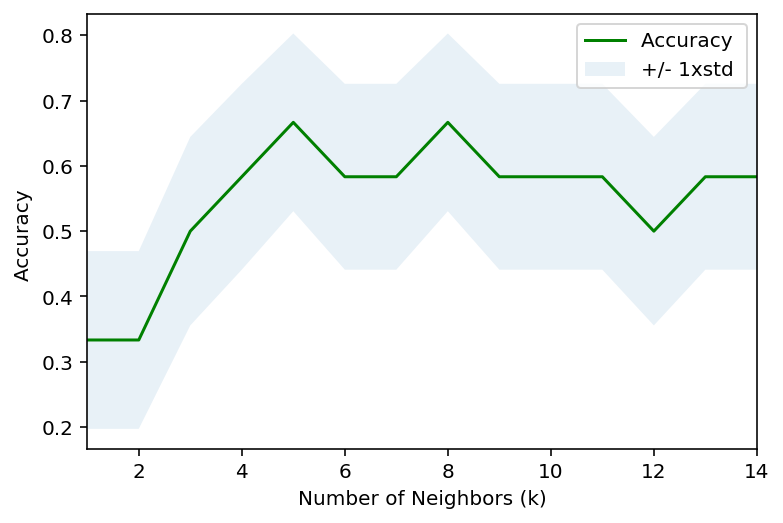

In [20]:
plt.plot(range(1, Ks), mean_acc, 'g')
plt.fill_between(range(1, Ks), mean_acc - 1*std_acc, mean_acc + 1*std_acc, alpha = 0.10)

plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (k)')

plt.xlim([1, Ks - 1]);

## Decision Tree

<font size=+1 color='firebrick'><b>Question 3:</b></font> Determine the minimum value for the parameter <code>max_depth</code> that improves results.

In [21]:
modeltree_acc = []

for md in range(2, 15):
    modeltree = DecisionTreeClassifier(criterion = 'entropy', max_depth = md)
    modeltree.fit(X_train, y_train)
    
    predTree = modeltree.predict(X_val)
    acc = accuracy_score(y_val, predTree)
    
    print ('Tree with max_depth = {:02d} | Accuracy = {}'.format(md, np.round(acc, 3)))
    modeltree_acc.append(accuracy_score(y_val, predTree))

Tree with max_depth = 02 | Accuracy = 0.667
Tree with max_depth = 03 | Accuracy = 0.5
Tree with max_depth = 04 | Accuracy = 0.333
Tree with max_depth = 05 | Accuracy = 0.417
Tree with max_depth = 06 | Accuracy = 0.417
Tree with max_depth = 07 | Accuracy = 0.5
Tree with max_depth = 08 | Accuracy = 0.417
Tree with max_depth = 09 | Accuracy = 0.5
Tree with max_depth = 10 | Accuracy = 0.417
Tree with max_depth = 11 | Accuracy = 0.417
Tree with max_depth = 12 | Accuracy = 0.5
Tree with max_depth = 13 | Accuracy = 0.5
Tree with max_depth = 14 | Accuracy = 0.417


In [22]:
# best value: max_depth = 2

modeltree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
modeltree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

## Support Vector Machine

<font size=+1 color='firebrick'><b>Question 4:</b></font> Train a support  vector machine model and determine the accuracy on the validation data for each kernel. Find the kernel (linear, poly, rbf, sigmoid) that provides the best score on the validation data and train a SVM using it.

In [23]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    clf = svm.SVC(kernel = kernel, gamma = 'auto').fit(X_train, y_train)
    yhat = clf.predict(X_val)
    
    acc = accuracy_score(y_val, yhat)
    
    print ('SVM with kernel={} | Accuracy = {}'. format(kernel, np.round(acc, 3)))

SVM with kernel=linear | Accuracy = 0.25
SVM with kernel=poly | Accuracy = 0.667
SVM with kernel=rbf | Accuracy = 0.583
SVM with kernel=sigmoid | Accuracy = 0.5


In [24]:
# best kernel: 'poly'
clf = svm.SVC(kernel = 'poly', gamma = 'auto')
clf.fit(X_train, y_train)

yhat = clf.predict(X_val)

print('SVM with kernel=poly | Accuracy = ', np.round(accuracy_score(y_val, yhat), 3))

SVM with kernel=poly | Accuracy =  0.667


## Logistic Regression

<font size=+1 color='firebrick'><b>Question 5:</b></font> Train a logistic regression model and determine the accuracy of the validation data (set C=0.01).

In [25]:
LR = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_train, y_train)

yhat = LR.predict(X_val)
yhat_prob = LR.predict_proba(X_val)

print ('LR | Accuracy = ', np.round(accuracy_score(y_val, yhat), 3))

LR | Accuracy =  0.583


# Model Evaluation using the Test Set

<font size=+1 color='firebrick'><b>Question 6:</b></font> Calculate the  F1 score and Jaccard Similarity score for each model from above. Use the hyperparameter that performed best on the validation data. **For f1_score please set the average parameter to 'micro'.**

## Load Test set for evaluation 

In [26]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/basketball_train.csv',error_bad_lines=False)
test_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


In [27]:
test_df.shape

(1757, 24)

In [28]:
test_df['windex'] = np.where(test_df.WAB > 7, 'True', 'False')

test_df1 = test_df[test_df['POSTSEASON'].str.contains('F4|S16|E8', na = False)]

test_Feature = test_df1[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
                         'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', 
                         '3P_O','3P_D', 'ADJ_T', 'WAB', 'SEED', 'windex']]
test_Feature['windex'].replace(to_replace = ['False', 'True'], value = [0, 1], inplace = True)
test_X = test_Feature
test_X = StandardScaler().fit(test_X).transform(test_X)

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [29]:
test_y = test_df1['POSTSEASON'].values
test_y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)

## kNN

In [30]:
neigh = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 
knn_pred = neigh.predict(test_X)

acc_knn = accuracy_score(test_y, knn_pred)
jc_knn = jaccard_index(test_y, knn_pred)
fs_knn = f1_score(test_y, knn_pred, average = 'micro')

In [31]:
print('kNN Classifier\n----------------')
print('Accuracy: ', np.round(acc_knn, 3))
print(' Jaccard: ', np.round(jc_knn, 3))
print('F1-score: ', np.round(fs_knn, 3))

kNN Classifier
----------------
Accuracy:  0.629
 Jaccard:  0.458
F1-score:  0.629


## Decision Tree

In [32]:
modeltree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2).fit(X_train, y_train) 
tree_pred = modeltree.predict(test_X)

acc_tree = accuracy_score(test_y, tree_pred)
jc_tree = jaccard_index(test_y, tree_pred)
fs_tree = f1_score(test_y, tree_pred, average = 'micro')

In [33]:
print('Decision Tree Classifier\n----------------')
print('Accuracy: ', np.round(acc_tree, 3))
print(' Jaccard: ', np.round(jc_tree, 3))
print('F1-score: ', np.round(fs_tree, 3))

Decision Tree Classifier
----------------
Accuracy:  0.643
 Jaccard:  0.474
F1-score:  0.643


## SVM

In [34]:
svm_pred = clf.predict(test_X)

acc_svm = accuracy_score(test_y, svm_pred)
jc_svm = jaccard_index(test_y, svm_pred)
fs_svm = f1_score(test_y, svm_pred, average = 'micro')

In [35]:
print('SVM Classifier\n----------------')
print('Accuracy: ', np.round(acc_svm, 3))
print(' Jaccard: ', np.round(jc_svm, 3))
print('F1-score: ', np.round(fs_svm, 3))

SVM Classifier
----------------
Accuracy:  0.686
 Jaccard:  0.522
F1-score:  0.686


## Logistic Regression

In [36]:
lr_pred = LR.predict(test_X)
proba = LR.predict_proba(test_X)

acc_lr = accuracy_score(test_y, lr_pred)
jc_lr = jaccard_index(test_y, lr_pred)
fs_lr = f1_score(test_y, lr_pred, average = 'micro')  
lloss = log_loss(test_y, proba)

In [37]:
print('Logistic Regression\n----------------')
print('Accuracy: ', np.round(acc_lr, 3))
print(' Jaccard: ', np.round(jc_lr, 3))
print('F1-score: ', np.round(fs_lr, 3))
print('Log-Loss: ', np.round(lloss, 3))

Logistic Regression
----------------
Accuracy:  0.686
 Jaccard:  0.522
F1-score:  0.686
Log-Loss:  1.037


# Report

We should be able to report the accuracy of the built models in the form of a table:

| Algorithm          | Accuracy | Jaccard  | F1-score  | LogLoss |
|--------------------|----------|----------|-----------|---------|
| KNN                |0.628571  | 0.458333 | 0.628571  | NA      |
| Decision Tree      |0.642857  | 0.473684 | 0.642857  | NA      |
| SVM                |0.685714  | 0.521739 | 0.685714  | NA      |
| LogisticRegression |0.685714  | 0.521739 | 0.685714  | 1.03719 |

In [38]:
dict_ = {'Accuracy': [acc_knn, acc_tree, acc_svm, acc_lr],
         'Jaccard': [jc_knn, jc_tree, jc_svm, jc_lr],
         'F1-score': [fs_knn, fs_tree, fs_svm, fs_lr],
         'LogLoss': ['NA', 'NA', 'NA', lloss]}

pd.DataFrame(dict_, index = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'])

,Accuracy,Jaccard,F1-score,LogLoss
KNN,0.628571,0.458333,0.628571,NA
Decision Tree,0.642857,0.473684,0.642857,NA
SVM,0.685714,0.521739,0.685714,NA
Logistic Regression,0.685714,0.521739,0.685714,1.03719


The SVM and Logistic Regression models perform better as they have higher values for all three metrics compared to the Decision Tree and kNN models. 

As the authors point out: 

'*Something to keep in mind when creating models to predict the results of basketball tournaments or sports in general is that is quite hard due to so many factors influencing the game. Even in sports betting an accuracy of 55% and over is considered good as it indicates profits.*'


# Future Development

As I have mentioned already, this is by no means a complete analysis. In a future version of this work, I am going to mainly focus on two topics:

- **Exploratory Data Analysis**: Performing a complete EDA could help us understand our dataset better and determine which features play a more crucial role in a team’s final position. Additionally, EDA could potentially assist us in engineering new features that would improve the performance of machine learning models.
- **Machine Learning**: This step could be improved in various ways. Initially, we could include more models (e.g. random forests,  gradient boosting algorithms, etc.). Moreover, hyperparameter tuning (using scikit-learn’s `GridSearchCV`) could be used to select the optimal hyperparameters for our models (i.e. highest possible accuracy without overfitting the training set). Finally, we could also try building an ensemble of different models and check if its performance exceeds all other individual models.



# Conclusions

Our notebook came to an end! In summary, we initially loaded the dataset using the Pandas library. The dataset contains information about four seasons of Division I college basketball. After taking a quick look at the data, we applied some basic pre-processing techniques. Finally, we built machine learning models using four different algorithms (kNN, decision trees, SVM, and Logistic Regression). Our model’s performance was evaluated on a test set using three metrics (Accuracy, Jaccard index, and F1-score). The SVM and Logistic Regression models perform better as they have higher values for all three metrics compared to the Decision Tree and kNN models. It is noteworthy that we can achieve an accuracy value approximately equal to 69%.

<br>

---

Most of the code up until the section titled 'Building Machine Learning Models' was written by the course authors [Azim Hirjani](https://www.linkedin.com/in/azim-hirjani-691a07179/) and [Joseph Santarcangelo](https://www.edx.org/bio/joseph-santarcangelo). The original notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.